#  Task Completion Prediction

<img src="https://www.techfunnel.com/wp-content/uploads/2019/01/Why-Human-Resources-Management-Is-Important-For-Every-Organization.jpg"
     width = "600"/>

# Table of Content: <a class="anchor" id="table-of-content"></a>
* [1. Problem Background and Motivation](#problem-background)
* [2. Libraries and Custom Functions](#import-packages)
* [3. Data Exploration/Prep](#data-prep)
* [4. Machine Learning Model](#ml-model)
* [5. Deployment of Model](#model-deployment)

# 1. Problem Background and Motivation <a class="anchor" id="problem-background"></a>

<img src='' width="700" />

>- High level outline
>- Brief background section
>>- What is the problem?
>>- Why is it important?
>>- Who are the key stakeholders?

<b>High level outline:</b>
This is a prediction model for predicting task completion based on the data provided by the HR department of a company.

<b>Brief background section</b>
The dataset has 74 datapoints and has the following features:
- Employee experience
- Training level

> <b>What is the problem?</b><br>
This problem deals with predicting the status of task completion for an organization. This is a resource allocation problem, and we can assume that this will impact the business operations on an organizational level.

> <b>Why is it important?</b><br>
With this prediction, the company will be better at managing its workforce, and will be able to assign tasks to available employees, therefore ensuring that the work goes uninterrupted and without any hitches.

> <b>Who are the key stakeholders?</b><br>
Accurately predicting the completion status of the tasks will largely benefit the company and may also be of interest to analytics firms and consulting firms who help with resource allocation.


* [Go to Top](#table-of-content)

# 2. Libraries & Custom Functions <a class="anchor" id="import-packages"></a>
* [Go to Top](#table-of-content)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import metrics


# Custom function below is used to display performance measures
# Required inputs are the model name and the two test data objects (X,y)
def class_perf_measures(model,X_test,y_test, initial_th, final_th, interval):
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    TP_per = []
    TN_per = []
    FP_per = []
    FN_per = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    
    # Create list of probability threshold values to loop over
    threshold = np.arange(initial_th,final_th + interval,interval).tolist()

    # Start loop
    for i in threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)

        # Append lists with metric values
        TP_value = metrics.confusion_matrix(y_test, y_test_pred_class)[1,1]
        TN_value = metrics.confusion_matrix(y_test, y_test_pred_class)[0,0]
        FP_value = metrics.confusion_matrix(y_test, y_test_pred_class)[0,1]
        FN_value = metrics.confusion_matrix(y_test, y_test_pred_class)[1,0]
        TP.append(TP_value)
        TN.append(TN_value)
        FP.append(FP_value)
        FN.append(FN_value)
        recall.append(metrics.recall_score(y_test, y_test_pred_class).round(3))
        precision.append(metrics.precision_score(y_test, y_test_pred_class).round(3))
        F1.append(metrics.f1_score(y_test, y_test_pred_class).round(2))
        Accuracy.append(metrics.accuracy_score(y_test, y_test_pred_class).round(2))
        TP_per.append(TP_value/(len(y_test))*100)
        TN_per.append(TN_value/(len(y_test))*100)
        FP_per.append(FP_value/(len(y_test))*100)
        FN_per.append(FN_value/(len(y_test))*100)

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "TP%": TP_per,
                           "TN%": TN_per,
                           "FP%": FP_per,
                           "FN%": FN_per,
                           "Precision":precision,
                           "Recall":recall,
                           "Accuracy": Accuracy,
                           "F1": F1
                          })

    # Let's look at our dataframe
    return result

def summaryStats(X,feature_list):
    temp = pd.DataFrame(dict(mean = X[feature_list].mean().round(2),
                             median = X[feature_list].median().round(2),
                             std_dev = X[feature_list].std().round(2),
                             min_val = X[feature_list].min().round(2),
                             max_val = X[feature_list].max().round(2),
                             missing_vals = X[feature_list].isnull().sum(),
                  potential_outlier = np.where( (X[feature_list].skew() > 3) | (X[feature_list].skew() < - 3) | (X[feature_list].kurt() > 10) | (X[feature_list].kurt() < -10),
                                                      True,False)
                            ))
    return temp

# 3. Data Preparation <a class="anchor" id="data-prep"></a>
    
* [1. Initial Data Evaluation](#data-evaluation)
* [2. Data Duplicates](#data-duplicates)
* [3. Explore the data and find outliers and missing values](#data-exploration)
* [4. Feature Selection](#feature-selection)
* [5. Data Partitioning](#data-partitioning)
* [6. Data Normalization](#normalization)
<br>

* [Go to Top](#table-of-content)

### 3.1 Initial Data Evaluation<a class="anchor" id="data-evaluation"></a>
>- First of all, we will read the .csv file into a dataFrame
>- We will read the tail of the data so that we will get some idea about number of records.
>- After that we try to make sense of the columns
>- Now we can spot the target variable
>- Finally we can predict which variables should be strongly correlated to target variable by first impression

In [2]:
df = pd.read_csv('SystemAdministrators.csv')
df.tail()

,task_completed,employee_experience,training_level4,training_level6,training_level8
70,1,11.40,1,0,0
71,1,11.70,0,0,1
72,0,12.20,1,0,0
73,1,12.40,1,0,0
74,1,13.70,0,1,0


In [3]:
print(df.shape)

(75, 5)


In [4]:
print(df.dtypes)

task_completed           int64
employee_experience    float64
training_level4          int64
training_level6          int64
training_level8          int64
dtype: object


**Obeservations:**

>- Dataset has only 75 records. This means as the dataset is not very large so there is no space for cleaning. By initial look, it looks like the data is already cleaned up 
>- The column names are pretty self explanatory and we don't need to modify any of them. Out of the 5 columns, 1 is continuous and the rest are binary. 
>- It looks like the training levels are categorical variables which are converted to binary. Categories are training level 4, training level 6, training level 8
>- task_completed is the obvious target variable. Value 1 signifies that the task is completed and 0 signifies that it is not completed.

>[Go to Data Prep Outline](#data-prep)

### 3.2 Data duplicates<a class="anchor" id="data-duplicates"></a>

>- Find and remove all the duplicate records
>- Use the inplace = True to change the existing dataFrame

The dataset is very small so we are not dropping any duplicates.
>[Go to Data Prep Outline](#data-prep)

### 3.3 Explore the data<a class="anchor" id="data-exploration"></a>

>- Describe the data
>- Find datatype 
>- Find missing values
>- Find the outliers
>- Decide the Naive Baseline

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
task_completed,75.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00
employee_experience,75.00,6.80,2.27,2.70,5.20,6.30,7.85,13.70
training_level4,75.00,0.76,0.43,0.00,1.00,1.00,1.00,1.00
training_level6,75.00,0.17,0.38,0.00,0.00,0.00,0.00,1.00
training_level8,75.00,0.07,0.25,0.00,0.00,0.00,0.00,1.00


In [6]:
numerical_vars = ['employee_experience']

summaryStats(df, numerical_vars)

,mean,median,std_dev,min_val,max_val,missing_vals,potential_outlier
employee_experience,6.80,6.30,2.27,2.70,13.70,0,False


In [7]:
df.dtypes

task_completed           int64
employee_experience    float64
training_level4          int64
training_level6          int64
training_level8          int64
dtype: object

In [8]:
print(len(df[df['task_completed'] == 0])/len(df))

0.8


**Observatios:**
>- All the datatypes look appropriate according to the column name.
>- No column has null values
>- There are no potential outliers
>- If all the tasks are predicted to be completed then the prediction would be accurate 80% of the time.

>[Go to Data Prep Outline](#data-prep)

### 3.4 Feature Selection<a class="anchor" id="feature-selection"></a>

>- Currently we have less number of predictor variables so we can consider all of them 

>[Go to Data Prep Outline](#data-prep)

### 3.5 Data Partitioning<a class="anchor" id="data-partitioning"></a>

>- Put all potential predictor variables into new object called 'X'
>- Put target variable in new object called 'y'
>- Partition the data into training set and testing set
>- Using small % of test data as we have very small sample

>[Go to Data Prep Outline](#data-prep)

In [9]:
target = ['task_completed']

X = df.drop(target,axis=1)
y = df[target]

# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25,random_state=5)

### 3.6 Data Normalization<a class="anchor" id="normalization"></a>

>- We do this AFTER splitting the data because we only want to use summary stats<br>
>- from the TRAINING data to normalize BOTH TRAIN and TEST data<br>
<br><br>
>OPTIONAL - though it is a good idea to get in the habit of doing this when working with the kNN classifier

>[Go to Data Prep Outline](#data-prep)

In [10]:
# Normalize predictor variables using Z-Scores.
# Use means and standard deviations of features as calculated in the TRAINING DATA
# New values are centered at 0.  Values reflect the number of standard deviations
# each record is above or below the mean.

features_means = X_train.mean()
features_std = X_train.std()

X_train = (X_train - features_means)/features_std
X_test = (X_test - features_means)/features_std

# 4. Machine Learning <a class="anchor" id="ml-model"></a>

- [X] [kNN](#kNN)
- [X] [Logistic Model](#lr-model)
- [X] [Decision Point](#decision-point)
- [x] [Performance Evaluation](#model-performance)


* [Go to Top](#table-of-content)

### 4.1 kNN<a class="anchor" id="kNN"></a>

>- Fit numerous kNN models using different values for k. <br>
>- Choose the "best" value for "k" based on Accuracy

In [11]:
# 1. train a classifier for different values of k
results = []
for k in np.arange(1,21,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train.values.ravel())
    
    # Get predicted class
    y_pred_class = knn.predict(X_test)
    
    # Put Accuracy Score in results object
    results.append({'k':k,
                    'accuracy':metrics.accuracy_score(y_test,y_pred_class),
                    'precision':metrics.precision_score(y_test,y_pred_class),
                    'recall':metrics.recall_score(y_test,y_pred_class)
                   }
                  )
# Put results from above into a Pandas Dataframe
results_df = pd.DataFrame(results)
results_df

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,k,accuracy,precision,recall
0,1,0.79,0.33,0.33
1,3,0.79,0.33,0.33
2,5,0.84,0.50,0.33
3,7,0.84,0.50,0.33
4,9,0.84,0.50,0.33
5,11,0.79,0.00,0.00
6,13,0.79,0.00,0.00
7,15,0.84,0.00,0.00
8,17,0.89,1.00,0.33
9,19,0.89,1.00,0.33


<AxesSubplot:xlabel='k', ylabel='accuracy'>

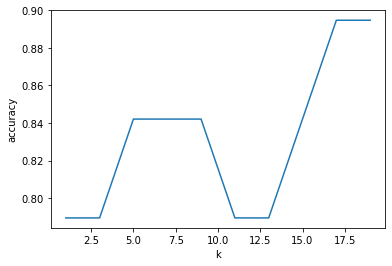

In [12]:
sns.lineplot(data=results_df, x='k',y='accuracy')

>**Decision:**<br>
>- Based on the results above, I will set my number of neighbors (k) to 9 as 9 is the lowest k where we are getting the highest accuracy 
>- Apart from accuracy, precision and recall for k=9 iare also good<br>

>**Re-run kNN using the value selected above:**<br>
For this final run of kNN, we will produce a table of performance measures across a range of probability threshold values

In [13]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train.values.ravel())

# Let's do a quick check to see if we have to worry about problems of overfitting.
# Remember!  Small values for "k" in kNN tend to lead to overfitting.
# Large value for "k" in kNN tend to produce underfit models
y_train_pred_class = knn.predict(X_train)
y_test_pred_class = knn.predict(X_test)

print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))


Training data Accuracy: 0.84
Testing data Accuracy: 0.89


In [14]:
class_perf_measures(knn, X_test, y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1
0,0.00,3,0,16,0,15.79,0.00,84.21,0.00,0.16,1.00,0.16,0.27
1,0.10,2,9,7,1,10.53,47.37,36.84,5.26,0.22,0.67,0.58,0.33
2,0.20,2,13,3,1,10.53,68.42,15.79,5.26,0.40,0.67,0.79,0.50
3,0.30,2,15,1,1,10.53,78.95,5.26,5.26,0.67,0.67,0.89,0.67
4,0.40,1,15,1,2,5.26,78.95,5.26,10.53,0.50,0.33,0.84,0.40
5,0.50,1,16,0,2,5.26,84.21,0.00,10.53,1.00,0.33,0.89,0.50
6,0.60,0,16,0,3,0.00,84.21,0.00,15.79,0.00,0.00,0.84,0.00
7,0.70,0,16,0,3,0.00,84.21,0.00,15.79,0.00,0.00,0.84,0.00
8,0.80,0,16,0,3,0.00,84.21,0.00,15.79,0.00,0.00,0.84,0.00
9,0.90,0,16,0,3,0.00,84.21,0.00,15.79,0.00,0.00,0.84,0.00


**Terminology:**
>- TP: Task is completed and it is predicted that it will be completed
>- TN: Task is not completed and it is predicted that it will not be completed
>- FP: Task is not completed but it is predicted that it will be completed 
>- FN: Task is completed but it is predicted that it will not be completed

* [Go to Machine Learning Model](#ml-model)

### 4.2 Logistic Model<a class="anchor" id="lr-model"></a>

>- Let's produce the same table above but this time using a Logistic Model

In [15]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train.values.ravel())

# Let's do a quick check to see if we have to worry about problems of overfitting.
# Remember!  Small values for "k" in kNN tend to lead to overfitting.
# Large value for "k" in kNN tend to produce underfit models
y_train_pred_class = lr_model.predict(X_train)
y_test_pred_class = lr_model.predict(X_test)

print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

Training data Accuracy: 0.91
Testing data Accuracy: 0.89


In [16]:
class_perf_measures(lr_model, X_test, y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1
0,0.00,3,0,16,0,15.79,0.00,84.21,0.00,0.16,1.00,0.16,0.27
1,0.10,3,11,5,0,15.79,57.89,26.32,0.00,0.38,1.00,0.74,0.55
2,0.20,2,12,4,1,10.53,63.16,21.05,5.26,0.33,0.67,0.74,0.44
3,0.30,2,15,1,1,10.53,78.95,5.26,5.26,0.67,0.67,0.89,0.67
4,0.40,2,15,1,1,10.53,78.95,5.26,5.26,0.67,0.67,0.89,0.67
5,0.50,2,15,1,1,10.53,78.95,5.26,5.26,0.67,0.67,0.89,0.67
6,0.60,1,15,1,2,5.26,78.95,5.26,10.53,0.50,0.33,0.84,0.40
7,0.70,1,15,1,2,5.26,78.95,5.26,10.53,0.50,0.33,0.84,0.40
8,0.80,0,15,1,3,0.00,78.95,5.26,15.79,0.00,0.00,0.79,0.00
9,0.90,0,15,1,3,0.00,78.95,5.26,15.79,0.00,0.00,0.79,0.00


**Terminology:**
>- TP: Task is completed and it is predicted that it will be completed
>- TN: Task is not completed and it is predicted that it will not be completed
>- FP: Task is not completed but it is predicted that it will be completed 
>- FN: Task is completed but it is predicted that it will not be completed

* [Go to Machine Learning Model](#ml-model)

### 4.3 Decision Point<a class="anchor" id="decision-point"></a>

Let's plot ROC for kNN and Log reg to find out which model has higher AUC

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


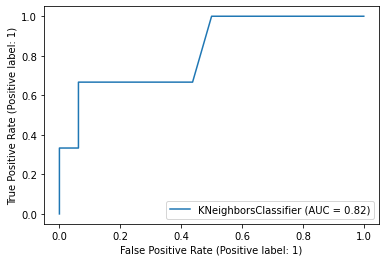

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


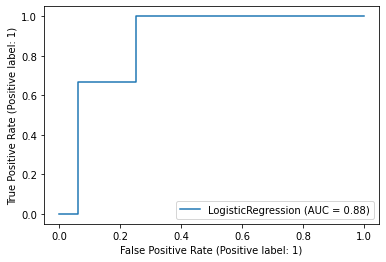

In [17]:
# ROC curve for kNN
metrics.plot_roc_curve(knn,X_test,y_test)
plt.show()

# ROC curve for Logistic Model
metrics.plot_roc_curve(lr_model,X_test,y_test)
plt.show()

AUC is more for Logistic model thank kNN. For now I will use logistic regression to further evaluate probability thresholds and corresponding performance measures

* [Go to Machine Learning Model](#ml-model)

### 4.4 Model Performance<a class="anchor" id="model-performance"></a>

>- Let's check the performance of the logistic model for different thresholds to find the best performing model

**Terminology:**
>- TP: Task gets completed and it is predicted that it will be completed
>- TN: Task does not get completed and it is predicted that it will not be completed
>- FP: Task does not get completed but it is predicted that it will be completed 
>- FN: Task gets completed but it is predicted that it will not be completed

**Analyzing possibilities**
>- 1. Effects of FP:<br> 
    i.   One employee will be assigned to multiple tasks as first task will not get completed before the next one is assigned.<br>
    ii.  As employees are not available, HR will need to postpone the tasks which are not urgent and employees have to work overtime for urgent tasks.<br>
    iii. Organization will have to pay extra for overtime.<br>
    iv.  HR will have to extend the deadlines<br>
>- 2. Effects of FN:<br>
    i.   HR will have to find tasks for employees who completed their task early.<br>
    ii.  If HR is not able to find the tasks then salaries for such employees will be liabilities for the organization<br>

**Decision**   
>- In this situation, the cost of FP is more than the cost of FN. We can solve the problems created by FN by finding new tasks to emplyees which shouldn't be of much problem as organisation never run out of work. But in case of FP we will have to face angry customers waiting for the task to be completed on time as well as angry employess who have to work over time.
>- FP is the costly perameter. Thus we want to minimise the FP and maximise the precision. 

In [18]:
class_perf_measures(lr_model, X_test, y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1
0,0.00,3,0,16,0,15.79,0.00,84.21,0.00,0.16,1.00,0.16,0.27
1,0.10,3,11,5,0,15.79,57.89,26.32,0.00,0.38,1.00,0.74,0.55
2,0.20,2,12,4,1,10.53,63.16,21.05,5.26,0.33,0.67,0.74,0.44
3,0.30,2,15,1,1,10.53,78.95,5.26,5.26,0.67,0.67,0.89,0.67
4,0.40,2,15,1,1,10.53,78.95,5.26,5.26,0.67,0.67,0.89,0.67
5,0.50,2,15,1,1,10.53,78.95,5.26,5.26,0.67,0.67,0.89,0.67
6,0.60,1,15,1,2,5.26,78.95,5.26,10.53,0.50,0.33,0.84,0.40
7,0.70,1,15,1,2,5.26,78.95,5.26,10.53,0.50,0.33,0.84,0.40
8,0.80,0,15,1,3,0.00,78.95,5.26,15.79,0.00,0.00,0.79,0.00
9,0.90,0,15,1,3,0.00,78.95,5.26,15.79,0.00,0.00,0.79,0.00


1. **Prob Threshold = 0.1**:

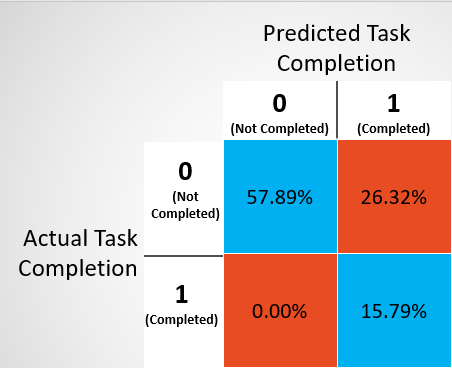

- Here threshold is 0.1 which means if probability of task completion is more than 0.1 then we will predict that task is completed. 
- In this case false positive means that task is actually not completed but it is predicted that will be completed. Where as false negative means task is predicted to be not completed but is actually completed.
- We have already discussed that FP are more costly than FN
- For 0.1 threshold, our model is predicting corectly for 74% of the times, for 26% times it is saying the task is completed but in reality it is not.
- Here precision is only 0.38 similarly accuracy can also be improved. We will check other thresholds and decide the threshold later.
<br><br>

2. **Prob Threshold = 0.5**:

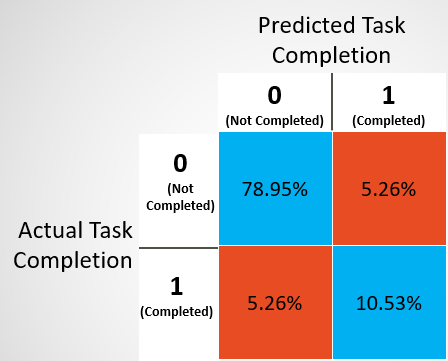

- Here threshold is 0.5 which means if probability of flight delay is more than 0.5 then we will predict that task is completed.
- Here precision is 0.67 which is more than the precision for th = 0.1
- Accuracy is 90%
- Along with precision, accuracy and F1 are also improved compared to th=0.1
- Recall is reduced but it is not costly in this case so we can afford low value of recall. 
- This threshold look much better than the previous one 
<br><br>

3. **Prob Threshold = 0.8**:

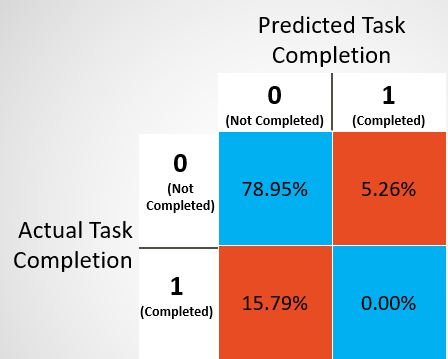

- Here threshold is 0.8 which means if probability of task completion is more than 0.8 then we will predict that task is completed. As this threshold is very high we expect very high percentage of negative predictions and we can see N% = 79 + 15 = 84%
- For this threshold, FP% is only 5% but FN% is 15%. 
- As there are no True Positive values, recall and precision are not useful in this case.
<br><br>
4. **Best threshold**
    - Considering all the thresold, 0.5 looks like the best scenario. 
    - 89% of the time prediction will be correct which is more that Naive Baseline.
    - 5.26% of the time, HR will have to find new tasks for the employees who have finished their work early. Where as 5.26% of the times, HR will have to add manpower or extend the deadline to the tasks which are not completed on time. 
    - As the number of tasks getting finished early are same as the task getting extended, HR can realloate the resources accordingly to solve both the problems.
    
* [Go to Machine Learning Model](#ml-model)

# 5. Deployment <a class="anchor" id="model-deployment"></a>

* [Go to Top](#table-of-content)

In [19]:
import pickle
pickle_out = open('taskCompletionPrediction', mode='wb')
pickle.dump([knn,lr_model,features_means,features_std,X_test.columns], pickle_out)
pickle_out.close()

In [20]:
%%writefile app.py

import pickle
import streamlit as st
import math
import pandas as pd
import numpy as np

pickle_in = open('taskCompletionPrediction', 'rb')
knn,lr_model,features_means,features_std,features = pickle.load(pickle_in)

@st.cache()

def prediction(classifier, employee_experience, training_level):
    
    #initialization
    training_levels = {'Traing Level 4':0,
                'Traing Level 6':0,
                'Traing Level 8':0}
    
    #value population
    for level in training_levels:
        if level == training_level:
            training_levels[level] = 1
            
    X_test_df = pd.DataFrame([[employee_experience,
            training_levels.get('Traing Level 4'),
            training_levels.get('Traing Level 6'),
            training_levels.get('Traing Level 8')]], 
        columns=features)
    
    #normalise the test data
    X_test_df = (X_test_df - features_means)/features_std
    
    # Make predictions
    if classifier == 'Logistic Regression':
        prediction = lr_model.predict_proba(X_test_df)
        THRESHOLD = 0.5
    else: 
        prediction = knn.predict_proba(X_test_df)
        THRESHOLD = 0.3
        
    if prediction[0][1] > THRESHOLD:
        return 'Task will be completed'
    else: 
        return 'Task will not becompleted'

# This is the main function in which we define our webpage
def main():
    
    st.title('Jarvis Task Completion Predictor')
    # Create input fields
    classifier = st.radio("Which model you want to use for prediction?",
                            ('kNN','Logistic Regression'))
    
    employee_experience = st.number_input("How experienced is the Employee?",
                                  min_value=2.0,
                                  max_value=14.0,
                                  value=7.0,
                                  step=0.5,
                                 )
               
    training_level = st.selectbox('Select the training level of employee',
                             ('Traing Level 4','Traing Level 6','Traing Level 8'))
    
    result = ""
    
    # When 'Predict' is clicked, make the prediction and store it
    if st.button("Will the task be completed?"):
        result = prediction(classifier, employee_experience, training_level)
        st.success(result)
        
if __name__=='__main__':
    main()

Overwriting app.py


In [ ]:
!streamlit run app.py